In [18]:
import pandas as pd
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

In [19]:
accidents = pd.read_csv("../PrometneNesreče.csv")

C:\Users\Hana\AppData\Local\Temp\ipykernel_62316\901670543.py:1: DtypeWarning: Columns (31,32,33,34,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents = pd.read_csv("../PrometneNesreče.csv")


In [20]:
# Priprava podatkov
accidents['NastanekDatumCas'] = pd.to_datetime(accidents['NastanekDatumCas'], format='ISO8601', errors='coerce')
print(f"NastanekDatumCas column dtype: {accidents['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns]


# CosinorPy - zima

In [21]:
winter_mask = accidents['NastanekDatumCas'].dt.month.isin([12, 1, 2])

winter_accidents = accidents[winter_mask]
# print(f"NastanekDatumCas column dtype: {winter_accidents['NastanekDatumCas'].dtype}")

hours = winter_accidents['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()
accidents_per_hour = accidents_per_hour.sort_index()

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsWinter",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

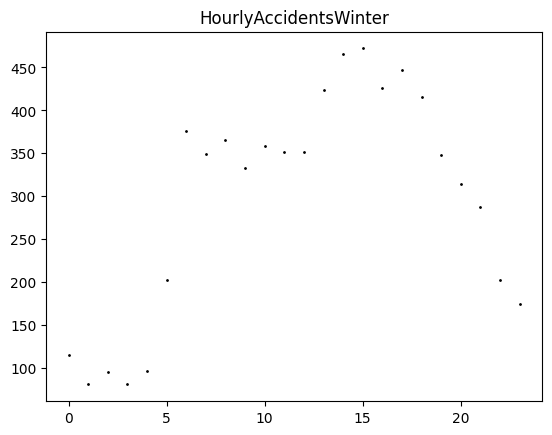

In [22]:
cosinor.plot_data(df_plot, names=["HourlyAccidentsWinter"])

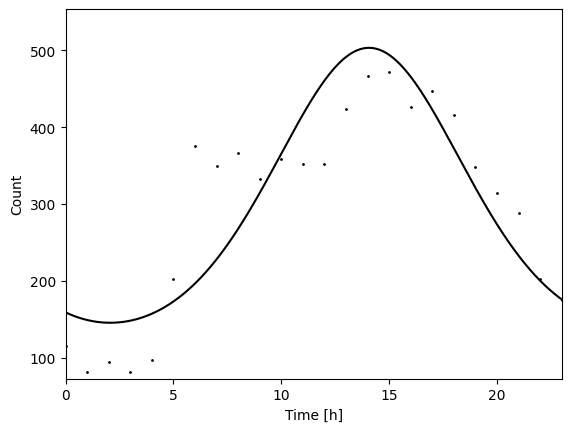

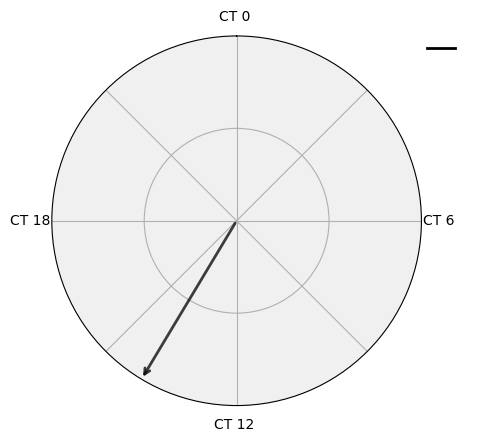

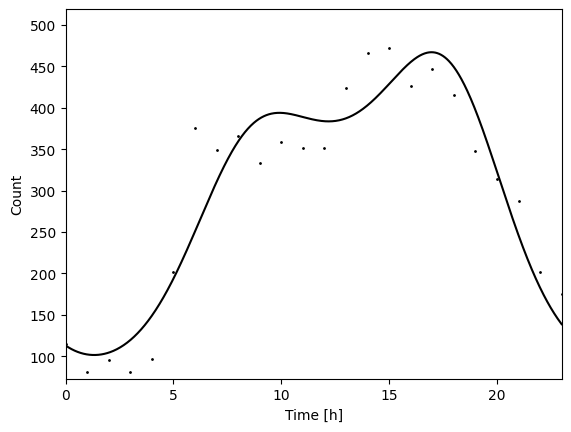

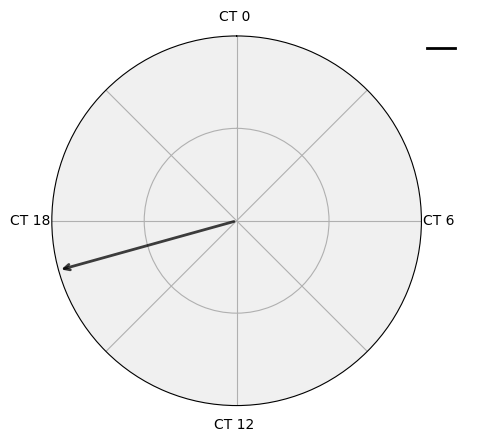

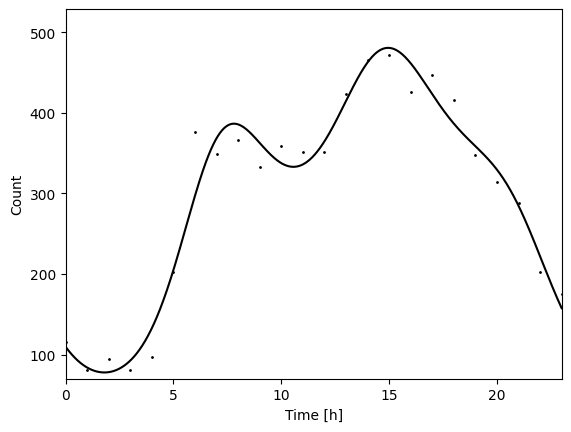

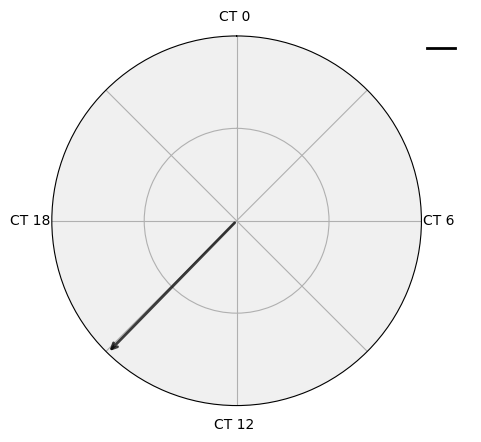

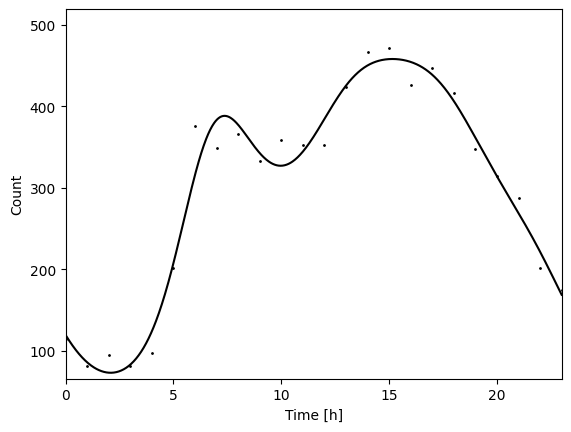

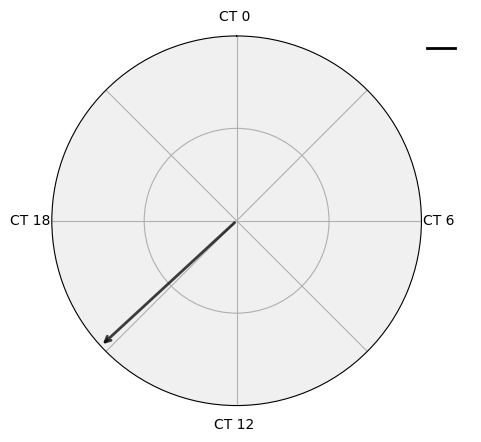

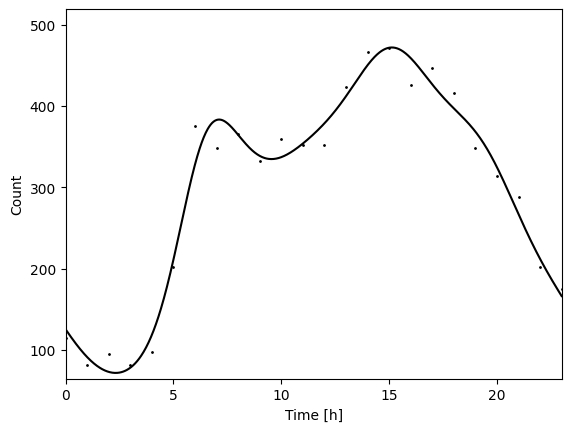

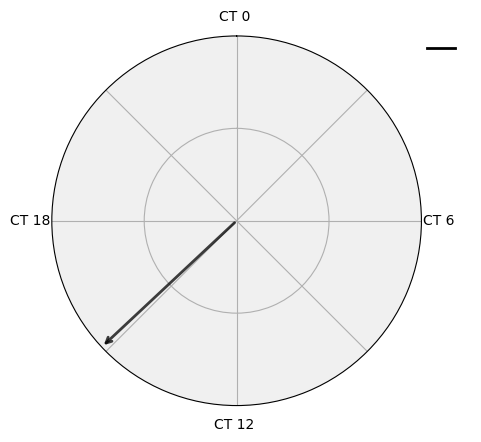

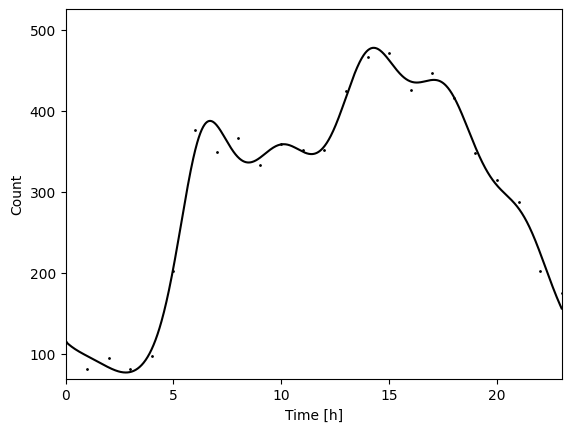

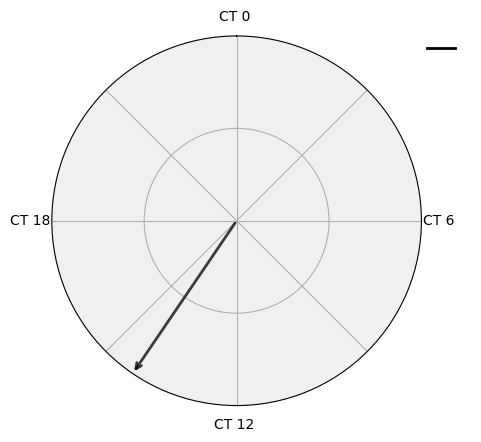

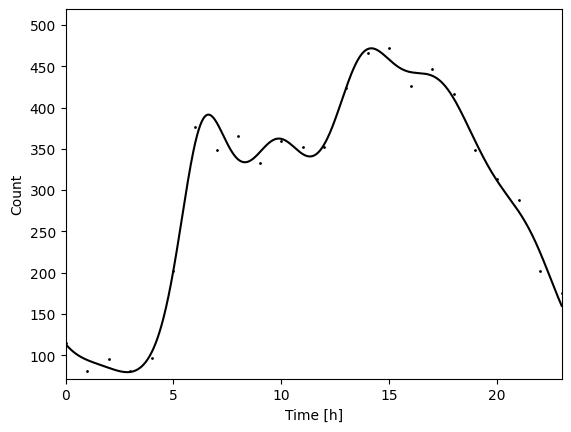

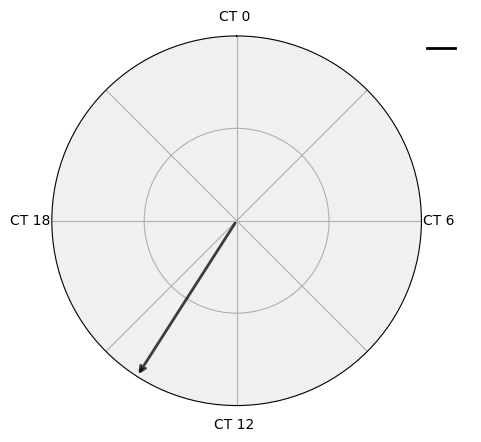

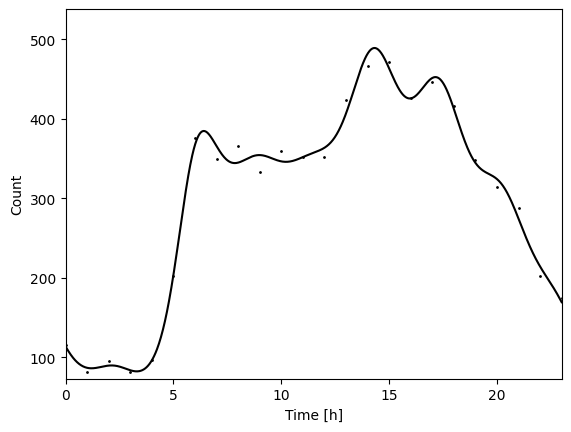

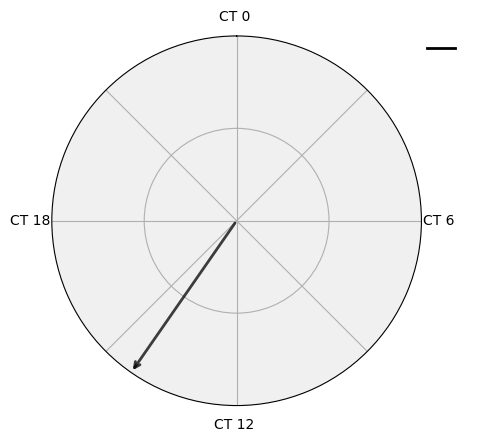

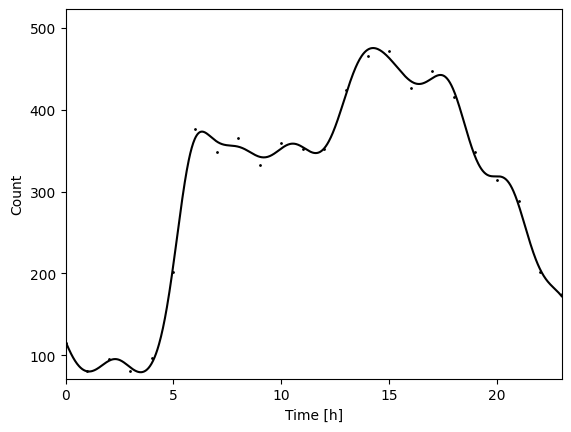

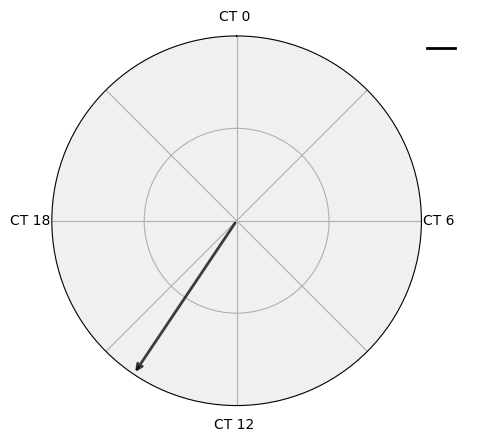

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


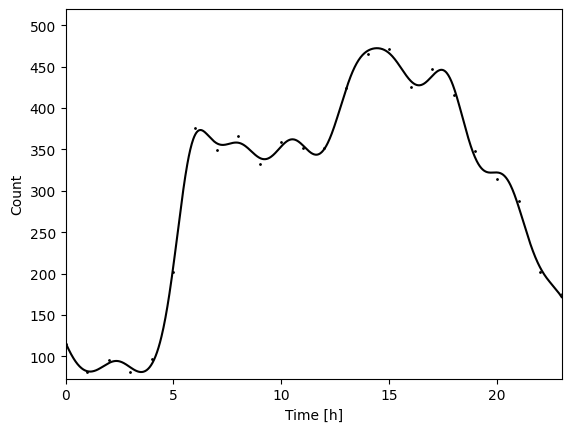

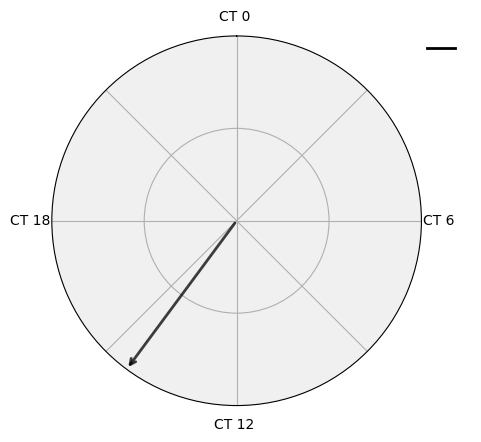

In [23]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsWinter', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsWinter', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsWinter',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [24]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsWinter,24.0,1.0,3.867510e-09,3.867510e-09,106630.267542,-134.772350,0.125667,178.719860,2.600870,324.382402,[14.065406540654067],[503.1022585170337],[2.069006900690069],[145.66255916851424],277.544699,282.256915
1,HourlyAccidentsWinter,24.0,2.0,1.326888e-12,1.474320e-12,44000.272520,-123.335106,0.199866,182.807945,1.841786,284.352756,"[9.912991299129914, 16.964896489648964]","[393.9744019303654, 467.1606334918641]",[1.3201320132013203],[101.54484353802168],258.670211,265.738534
2,HourlyAccidentsWinter,24.0,3.0,9.444666e-17,1.349238e-16,14392.922521,-110.332262,0.284221,201.480409,2.368369,279.223642,"[7.805580558055806, 14.953495349534954]","[386.5670743462713, 480.7040510973675]",[1.7953795379537956],[77.74323224454474],236.664523,246.088954
3,HourlyAccidentsWinter,24.0,4.0,6.002779e-17,1.000463e-16,10797.128836,-106.956494,0.306122,192.461971,2.315585,265.554980,"[7.36873687368737, 15.155115511551156]","[388.27938221383226, 458.0169248137261]",[2.0882088208820884],[73.09300809272276],233.912987,245.693525
4,HourlyAccidentsWinter,24.0,5.0,1.581045e-16,1.976306e-16,9316.337920,-105.299774,0.316870,200.334399,2.323126,271.832681,"[7.114311431143115, 15.126312631263128]","[383.4390232686156, 472.16707998879843]",[2.3186318631863188],[71.49828183983927],234.599548,248.736194
5,HourlyAccidentsWinter,24.0,6.0,1.286642e-18,3.216606e-18,4371.144355,-97.457897,0.367744,200.559385,2.544316,277.328289,"[6.696669666966697, 10.10981098109811, 14.2814...","[387.5985861950663, 358.7980232030166, 477.887...",[2.789078907890789],[76.76890422950595],222.915794,239.408547
6,HourlyAccidentsWinter,24.0,7.0,5.411459e-18,1.082292e-17,4548.247397,-96.534385,0.373735,196.121148,2.571965,275.623687,"[6.619861986198621, 9.884188418841886, 14.1758...","[391.4221629183506, 362.4329306708534, 471.744...",[2.8562856285628566],[79.50255737914313],225.068771,243.917632
7,HourlyAccidentsWinter,24.0,8.0,3.303510e-20,1.101170e-19,2752.545539,-88.400613,0.426503,203.515033,2.534262,285.666857,"[6.403840384038404, 8.976897689768977, 14.3198...","[384.7166687046007, 354.38910178699604, 489.18...","[1.2001200120012, 3.297929792979298]","[86.0303038704057, 82.15190801817769]",212.801227,234.006196
8,HourlyAccidentsWinter,24.0,9.0,4.670053e-23,4.670053e-22,1147.332878,-78.623965,0.489928,198.074885,2.550600,277.371835,"[6.322232223222323, 10.532253225322533, 14.257...","[373.31954132832686, 358.61874839756223, 475.4...","[1.084908490849085, 3.4803480348034808]","[80.1945489629604, 79.29695061263479]",197.247931,220.809008
9,HourlyAccidentsWinter,24.0,10.0,1.127584e-22,5.637919e-22,898.103220,-77.197675,0.499181,195.818382,2.504100,276.656111,"[6.250225022502251, 7.901590159015902, 10.5178...","[373.5253033522988, 358.37308782233515, 362.28...","[1.1377137713771377, 3.5043504350435044]","[81.39283802727063, 80.8378842131557]",198.395350,224.312534


### Katero je najboljše število komponent

In [25]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model
#print(df_best_model)

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsWinter,24,3,9.444666e-17,14392.922521,-110.332262,0.284221,236.664523,246.088954,201.480409,2.368369,279.223642,"[7.805580558055806, 14.953495349534954]","[386.5670743462713, 480.7040510973675]",[1.7953795379537956],[77.74323224454474]


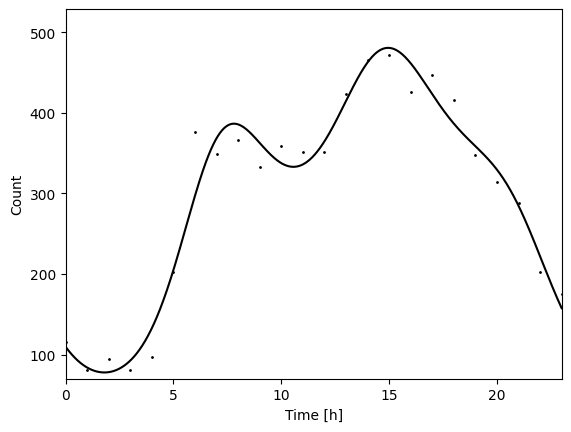

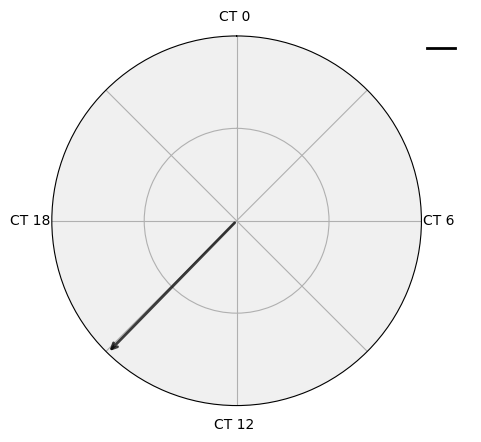

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x26855ecd580>,
 {'p': 9.444665898953295e-17, 'RSS': 14392.92252100283, 'count': 7136},
 {'period': 24,
  'amplitude': 201.48040942641137,
  'acrophase': 2.3683693792139073,
  'mesor': 279.2236416709561,
  'peaks': array([ 7.80558056, 14.95349535]),
  'heights': array([386.56707435, 480.7040511 ]),
  'troughs': array([1.79537954]),
  'heights2': array([77.74323224]),
  'max_loc': 3115,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([109.58628754, 109.40988105, 109.23399995, ..., 109.94067711,
        109.76321952, 109.58628754]))

In [26]:
# cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-zima", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [27]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsWinter",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [28]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

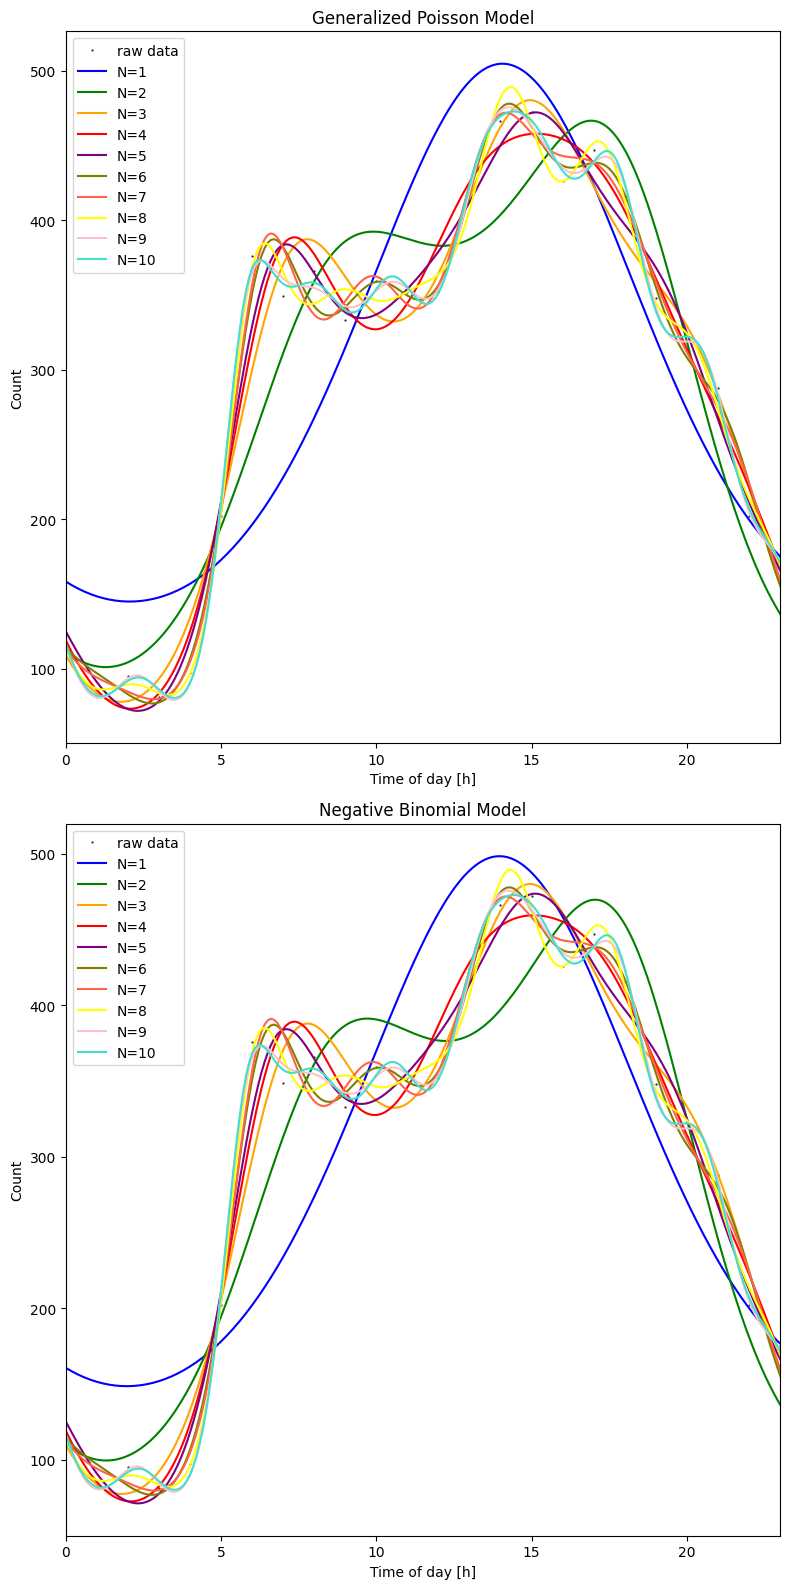

In [29]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [30]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,179.87,324.74,[14.01],[504.6],3.886549e-09,107496.947000,277.554521,282.266736,-134.777260,"[-4.9299973208070185, -5.531664902322518, -5.0...",297.342620,"[158.31237196104547, 148.3803805557247, 144.87...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[158.31237196104547, 157.01603976858797, 155.7..."
1,gen_poisson,2,182.75,283.77,"[9.91, 16.92]","[392.29, 466.52]",1.355760e-12,43341.828697,258.714660,265.782983,-123.357330,"[-4.258688954659078, -4.298567682918886, -4.14...",296.352067,"[111.73197320761611, 101.52807506977148, 104.1...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[111.73197320761611, 110.08845793697718, 108.5..."
2,gen_poisson,3,201.19,279.01,"[7.81, 14.91]","[387.21, 480.21]",2.215127e-16,14246.421574,238.449859,247.874290,-111.224930,"[-3.623948067045717, -3.3616280406404826, -4.5...",297.333333,"[109.16045188284137, 83.64118677668645, 78.276...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[109.16045188284137, 105.61843321302955, 102.3..."
3,gen_poisson,4,192.29,265.49,"[7.41, 15.12]","[388.48, 457.78]",3.889346e-16,10760.915952,237.903707,249.684246,-108.951854,"[-3.3678267031035745, -3.255121494940397, -6.1...",297.333333,"[119.16509931522268, 85.78923167333832, 73.267...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[119.16509931522268, 114.95227406560147, 110.9..."
4,gen_poisson,5,200.17,271.92,"[7.11, 15.12]","[383.82, 472.09]",3.913999e-16,9341.203768,236.572185,250.708831,-106.286093,"[-3.7111817804954654, -3.700018843649019, -6.1...",297.333333,"[125.0907361537051, 91.12139753927195, 72.9949...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[125.0907361537051, 121.25293552799258, 117.48..."
5,gen_poisson,6,200.59,277.31,"[6.71, 10.11, 14.31, 17.12]","[387.25, 358.9, 477.91, 438.29]",1.310704e-18,4364.451844,222.956362,239.449116,-97.478181,"[-3.1812006143293274, -4.743748355548021, -4.1...",297.333333,"[114.80911614516384, 96.97501703738044, 82.862...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[114.80911614516384, 112.36357896702565, 110.1..."
6,gen_poisson,7,196.13,275.67,"[6.61, 9.91, 14.21]","[391.11, 362.61, 471.8]",5.938732e-18,4545.480567,225.275916,244.124778,-96.637958,"[-3.1923020987514263, -4.201826871249452, -3.8...",297.333333,"[113.47925029552847, 94.08456730588381, 84.599...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[113.47925029552847, 110.51459929085343, 107.8..."
7,gen_poisson,8,203.40,285.76,"[6.41, 14.31, 17.12]","[384.71, 489.16, 452.73]",4.982138e-19,2750.403860,218.879630,240.084599,-91.439815,"[-3.1903176086582477, -3.244905776363453, -3.2...",297.333333,"[113.61183673010285, 86.61458218182683, 89.456...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[113.61183673010285, 108.96016652804494, 104.7..."
8,gen_poisson,9,198.21,277.23,"[6.31, 10.51, 14.21, 17.42]","[373.04, 358.78, 475.43, 442.49]",2.880277e-19,1141.634104,216.897484,240.458561,-88.448742,"[-3.1992747593478583, -3.006835920283663, -3.1...",297.333333,"[116.74406403380232, 80.61729551324505, 93.422...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[116.74406403380232, 110.5817610327208, 104.83..."
9,gen_poisson,10,196.14,276.51,"[6.21, 7.91, 10.51, 14.41, 17.42]","[373.28, 358.35, 362.45, 472.65, 446.3]",1.697955e-18,891.847170,220.364275,246.281459,-88.182137,"[-3.190205291037273, -3.0161275741505875, -3.1...",297.333333,"[116.20294842546895, 82.04723845291602, 91.780...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[116.20294842546895, 110.54252239032155, 105.2..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [31]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 6


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [32]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 6
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

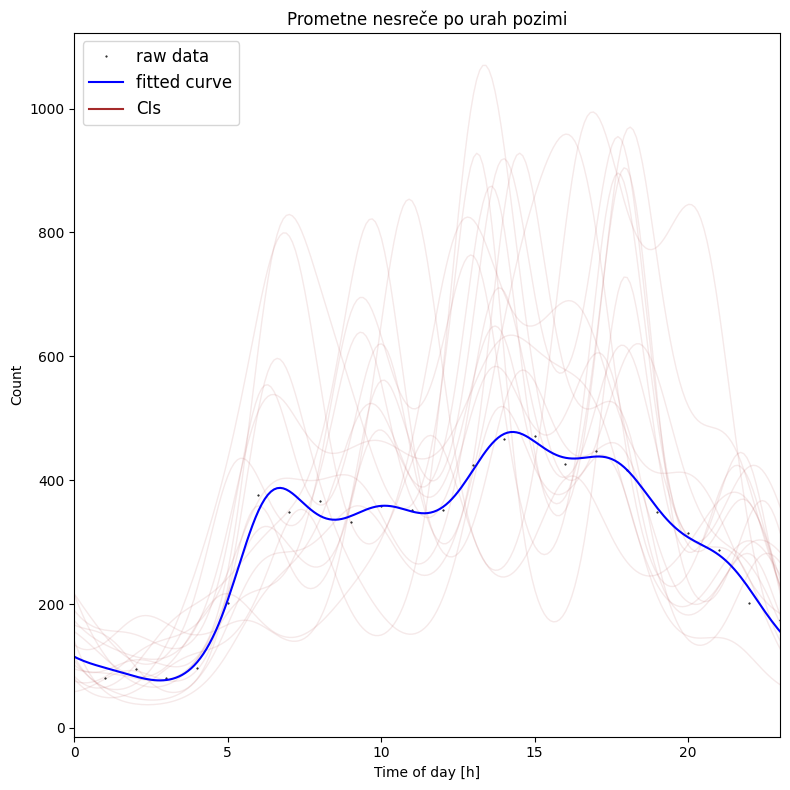

Intervali zaupanja:


,0,1
0,5.315470,5.777774
1,-0.654157,0.067252
2,-0.810229,-0.471196
3,-0.461243,0.042129
4,-0.517238,-0.004709
5,-0.382775,0.082054
6,-0.168293,0.302524
7,-0.203397,0.186452
8,-0.195185,0.350658
9,-0.238299,0.255491


In [33]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah pozimi', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [34]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,6
amplitude,200.59
mesor,277.31
peaks,"[6.71, 10.11, 14.31, 17.12]"
heights,"[387.25, 358.9, 477.91, 438.29]"
amplitude_CIs,"[84.24, 353.18]"
mesor_CIs,"[160.53, 428.06]"
peaks_CIs,"[[6.06, 7.43], [9.37, 11.01], [13.81, 14.76], ..."
heights_CIs,"[[341.12, 464.73], [46.31, 814.44], [313.13, 6..."
